# Neural Network Thermometer - Ising 2D Onsager Scale

Given a set of spin configurations, we would like to construct an empirical probability distribution in order to find the most probable temperature value of this set. 

Here we follow the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172), where a neural network is trained with labeled Monte Carlo Ising configurations, defining a thermometer with temperature scale given by the training set.

Firstly, we load the necessary libraries, including [PyTorch](https://pytorch.org/), a suitable python library for deep learning models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(12)


from MC_Ising2D import IsingMC
from net import Net
T_c = 2 / ( np.log(1 + np.sqrt(2)) )

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L100_Ising2D_MC.pkl` was constructed considering a square lattice $L\times L$, with $L=100$. There are 1000 spins configurations for each of 29 different temperatures $ T/J = 1, 1.1, 1.2, ..., 3.5 $ and $ T/J = 2.259, 2.269, 2.279$..

In [2]:
ising_data = pd.read_pickle('data/L100_Ising2D_MC.pkl')
ising_data.head()

,energy,magn,state,temp
0,-6656,176,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",3.5
1,-6872,-248,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...",3.5
2,-6812,544,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...",3.5
3,-6616,-166,"[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...",3.5
4,-6660,-68,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",3.5


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


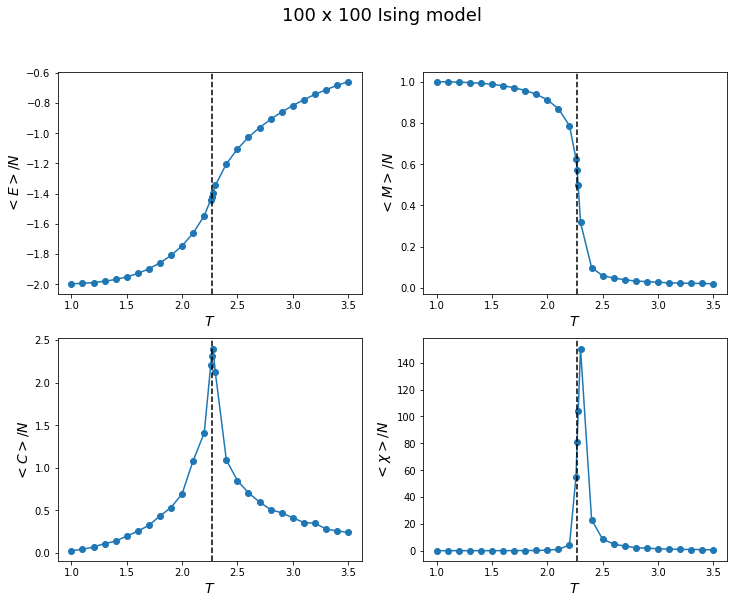

In [3]:
IsingMC(L= 100).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$


Since our goal is to measure temperature, the target labels for the samples `ising_data['state']` of our supervised learning must be constructed with the information given by the columns `ising_data['temp']`. 

In [4]:
data = ising_data.drop(columns= ['energy', 'magn'])

## Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 29 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [5]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

## One-hot encoding

It is interesting to translate the targets into an [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) structure. 

In [6]:
train_data = pd.get_dummies(train_data_, columns=['temp'])
test_data = pd.get_dummies(test_data_, columns=['temp'])

## Creating a PyTorch dataset

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [7]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float).cuda()
y_train = torch.tensor(np.array(train_data[list(train_data.columns.values[1:])]), dtype= torch.float).cuda()

X_test = torch.tensor(list(test_data['state']), dtype= torch.float).cuda()
y_test = torch.tensor(np.array(test_data[list(test_data.columns.values[1:])]), dtype= torch.float).cuda()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([23200, 10000])
torch.Size([23200, 29])
torch.Size([5800, 10000])
torch.Size([5800, 29])


In [8]:
batch_size = 100

train_loader = DataLoader(TensorDataset(X_train, y_train), 
                          batch_size= batch_size, 
                          shuffle= True)

## Training

The neural network is constructed in the class `Net`. Its code is available in the python script `net.py`.

We also have to define the network architecture, optimizer and loss function.

In [9]:
### Defining network architecture

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 512, 256, 64]


### Initializing the class and defining the number of epochs

net = Net(layers_size, 
          out_size).cuda()     

epochs = 160

print(net)


### Defining optimizer and loss training 

optimizer = optim.SGD(net.parameters(), 
                      lr= 0.1, 
                      weight_decay= 0.0)

loss_func = nn.BCELoss()


### Dictionary to record the results 

log_dic = {
    'epoch': [],
    'loss_train' : [],
    'loss_test' : [],
}


### Training 

for epoch in range(epochs):
    
    t0 = time.time()
    
    loss_epoch = []
    
    ### Loop over mini-batches
       
    for _, (input_data, target) in enumerate(train_loader):
        
        prediction= net(input_data)
        
        loss = loss_func(prediction, target)     
        
        loss_epoch.append(loss.item())
          
        optimizer.zero_grad()   # Clear gradients for the next mini-batches
        loss.backward()         # Backpropagation, compute gradients
        optimizer.step()
               
    ### Recording some results
    log_dic['epoch'].append(epoch)
    log_dic['loss_train'].append(np.mean(loss_epoch))
    test_error_ep = loss_func(net(X_test), y_test).item()
    log_dic['loss_test'].append(test_error_ep)
    t1 = time.time()
    
    ### Training status
    print('Epoch %d, Loss_train= %.10f, Loss_test= %.10f, Time= %.4f' % (epoch, 
                                                                         np.mean(loss_epoch), 
                                                                         test_error_ep, 
                                                                         t1-t0))

Net(
  (layers): ModuleList(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=29, bias=True)
)
Epoch 0, Loss_train= 0.1497440631, Loss_test= 0.1489499062, Time= 4.0592
Epoch 1, Loss_train= 0.1482871360, Loss_test= 0.1473834217, Time= 3.3559
Epoch 2, Loss_train= 0.1464277483, Loss_test= 0.1453187764, Time= 3.0531
Epoch 3, Loss_train= 0.1441401404, Loss_test= 0.1429443806, Time= 3.0519
Epoch 4, Loss_train= 0.1417454495, Loss_test= 0.1406594068, Time= 3.2671
Epoch 5, Loss_train= 0.1395849368, Loss_test= 0.1386905760, Time= 3.3169
Epoch 6, Loss_train= 0.1377632070, Loss_test= 0.1370429844, Time= 3.4607
Epoch 7, Loss_train= 0.1362008196, Loss_test= 0.1355971843, Time= 3.2037
Epoch 8, Loss_train= 0.1347831860, Loss_test= 0.1342526227, Time= 3.0869
Epoch 9, Loss_train= 0.1334392868, Loss_test= 0.1329750866, T

Epoch 107, Loss_train= 0.0913651929, Loss_test= 0.0999684036, Time= 3.1467
Epoch 108, Loss_train= 0.0914999766, Loss_test= 0.1057161316, Time= 3.2502
Epoch 109, Loss_train= 0.0909061552, Loss_test= 0.1040400863, Time= 3.2089
Epoch 110, Loss_train= 0.0910846312, Loss_test= 0.0999970362, Time= 3.2346
Epoch 111, Loss_train= 0.0906417610, Loss_test= 0.1034675315, Time= 3.2036
Epoch 112, Loss_train= 0.0904301361, Loss_test= 0.1064664945, Time= 3.1605
Epoch 113, Loss_train= 0.0905054004, Loss_test= 0.1001943573, Time= 3.1949
Epoch 114, Loss_train= 0.0901207823, Loss_test= 0.1001297086, Time= 3.3818
Epoch 115, Loss_train= 0.0897584609, Loss_test= 0.0995475426, Time= 3.1509
Epoch 116, Loss_train= 0.0895831675, Loss_test= 0.0996280611, Time= 3.1389
Epoch 117, Loss_train= 0.0893176670, Loss_test= 0.1020655259, Time= 3.1171
Epoch 118, Loss_train= 0.0891056124, Loss_test= 0.1016216651, Time= 3.1572
Epoch 119, Loss_train= 0.0892072526, Loss_test= 0.1001564264, Time= 3.1566
Epoch 120, Loss_train= 0.

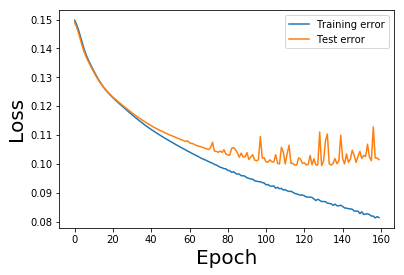

In [12]:
plt.plot(log_dic['epoch'], log_dic['loss_train'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_test'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend()
plt.show()

### Saving the trained model to a file

In [13]:
torch.save(net, 'NN_trained_models/L100_NN_Ising2D_MC.pt')

## Measuring temperatures with the trained neural network

As a sanity check, we use the trained neural network to construct the empirical probability temperature distribution for each set of labeled configurations in the test dataset. If the thermometer works fine, the empirical probabilities should be centered around the reference values.

To clean the presentation, we define a suitable plot function.

In [54]:
def thermometer(data,
                T_list,
                x_min= min(T_list), x_max= max(T_list)):
    
    for _, temp in enumerate(T_list):
        
           
        ising_state_temp = data[data['temp'] == temp]['state']
    
        X_ising_test = torch.tensor(list(ising_state_temp), dtype= torch.float).cuda()
    
        prediction= net(X_ising_test)
    
        x_ = np.sort(data['temp'].value_counts().index)
    
        plt.plot(x_,
                 prediction.cpu().mean(dim=0).data.numpy(),
                 marker= '.',
                 label= 'T = %.3f' % temp )
    
        plt.axvline(x= temp, linestyle= ':', linewidth= 0.5, color= 'gray')
    
        plt.xlabel('Temperature ', fontsize= 15)
        plt.ylabel('Empirical probability', fontsize= 15)

    plt.legend(loc= 'center left', bbox_to_anchor=(1, 0.5), fontsize= 'small')
    plt.xlim([x_min, x_max])
    plt.show()

Defining a list encompassing the temperature scale, we can use the function `thermometer` to plot the empirical probability temperatures.

In [22]:
T_list = test_data_['temp'].value_counts().index.tolist()
T_list.sort()

The dashed lines are the labeled temperature values.

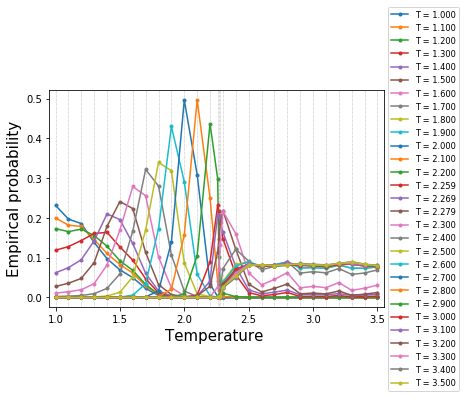

In [55]:
thermometer(test_data_, 
            T_list,
            x_min= min(T_list) - 0.05, x_max= max(T_list) + 0.05)

The behavior of the thermometer is quite similar to the one in the paper [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172). It is difficult to distinguish low and high temperatures values, while the peaks around the critical temperature of this scale are evident.

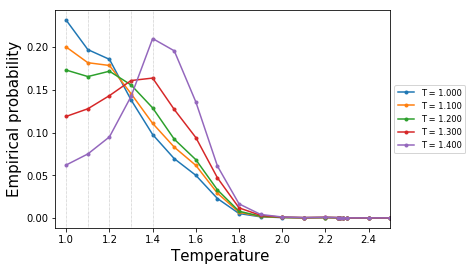

In [56]:
thermometer(test_data_, 
            T_list[:5],
            x_min= min(T_list[:5]) - 0.05, x_max= 2.5)

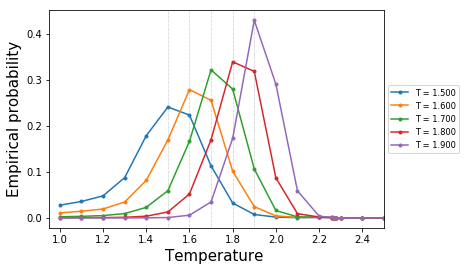

In [57]:
thermometer(test_data_, 
            T_list[5:10],
            x_min= min(T_list[:5]) - 0.05, x_max= 2.5)

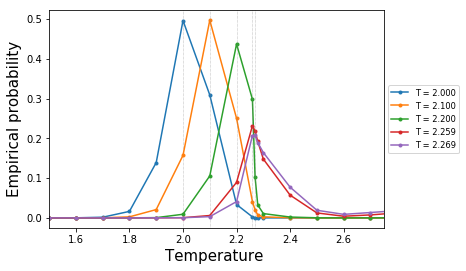

In [58]:
thermometer(test_data_, 
            T_list[10:15],
            x_min= 1.5, x_max= 2.75)

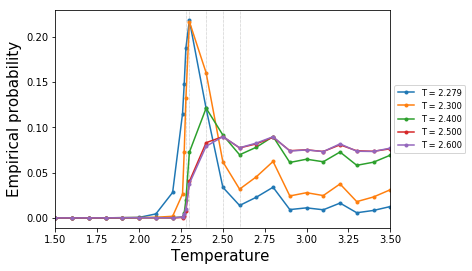

In [59]:
thermometer(test_data_, 
            T_list[15:20],
            x_min= 1.5, x_max= 3.5)

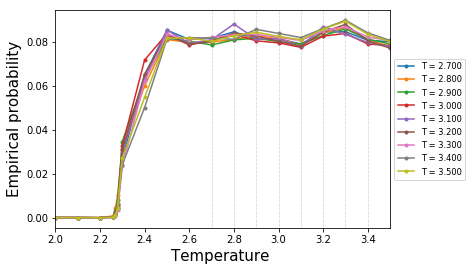

In [62]:
thermometer(test_data_, 
            T_list[20:29],
            x_min= 2.0, x_max= 3.5)